In [1]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

Set all the Constants

In [82]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=35
train_size = 0.8
validation_size = 0.1
test_size = 0.1

In [3]:
#creating tf datasets
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato-disease",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)

68

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
i = 0
for image_batch, labels_batch in dataset.take(1):  #dataset.take(1) --> takes first batch of tf dataset 
    print(image_batch.shape)#(32, 256, 256, 3)  --> 32 images of 256*256 where there is 3 channel i.e red,green and blue(rgb)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 2 0 1]


In [7]:
dataset.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

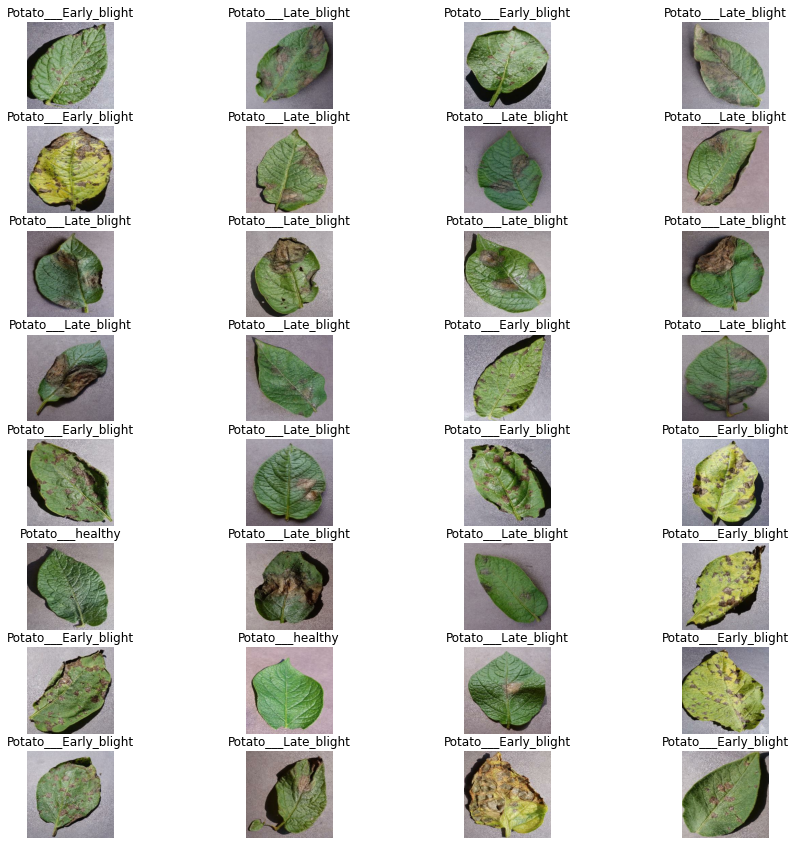

In [8]:
# Visualize some of the images from our dataset
plt.figure(figsize=(15, 15)) # size of total plot 
for image_batch, labels_batch in dataset.take(1):
    for i in range(32): #first 12 images
        ax = plt.subplot(8,4, i + 1)  # 8 rows 4 colums for 32 images 
        ax.set_axis_off()
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        #plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training ,
Validation: Dataset to be tested against while training ,
Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(int(len(dataset)*train_size))
test_ds = dataset.skip(int(len(dataset)*train_size))

In [11]:
print(len(train_ds))
print(len(test_ds))

54
14


In [12]:
# now we create validation dataset from test_ds
val_ds = test_ds.take(int(len(dataset)*validation_size))
test_ds = test_ds.skip(int(len(dataset)*validation_size)) 

In [13]:
print(len(val_ds))
print(len(test_ds))

6
8


In [14]:
# function for dataset split process
def get_dataset_partitions_tf(ds, train_split=train_size, val_split=validation_size, test_split=test_size, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Cache, Shuffle, and Prefetch the Dataset

In [16]:
# from shuffle go though once the below article 
#  https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [79]:
#model Architecture 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),#resizing the images
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),#augmentation
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (32, 256, 256, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (32, 256, 256, 3)         0         
                                                                 
 random_flip_3 (RandomFlip)  (32, 256, 256, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (32, 256, 256, 3)        0         
 tation)                                                         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                 

In [81]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [83]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/35
54/54 [==============================] - 225s 4s/step - loss: 0.8991 - accuracy: 0.4751 - val_loss: 0.7976 - val_accuracy: 0.5885
Epoch 2/35
54/54 [==============================] - 214s 4s/step - loss: 0.6648 - accuracy: 0.7147 - val_loss: 0.6980 - val_accuracy: 0.6406
Epoch 3/35
54/54 [==============================] - 205s 4s/step - loss: 0.4918 - accuracy: 0.7934 - val_loss: 0.4660 - val_accuracy: 0.8125
Epoch 4/35
54/54 [==============================] - 189s 4s/step - loss: 0.3474 - accuracy: 0.8565 - val_loss: 0.3301 - val_accuracy: 0.8594
Epoch 5/35
54/54 [==============================] - 186s 3s/step - loss: 0.2854 - accuracy: 0.8814 - val_loss: 0.3261 - val_accuracy: 0.8646
Epoch 6/35
54/54 [==============================] - 187s 3s/step - loss: 0.2771 - accuracy: 0.8877 - val_loss: 0.2758 - val_accuracy: 0.8854
Epoch 7/35
54/54 [==============================] - 192s 4s/step - loss: 0.1935 - accuracy: 0.9196 - val_loss: 0.2261 - val_accuracy: 0.9167
Epoch 8/35
54

In [84]:
#test the model accuracy
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 1s/step - loss: 0.0801 - accuracy: 0.9727


In [85]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [86]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
plt.plot( accc, label='Training Accuracy')

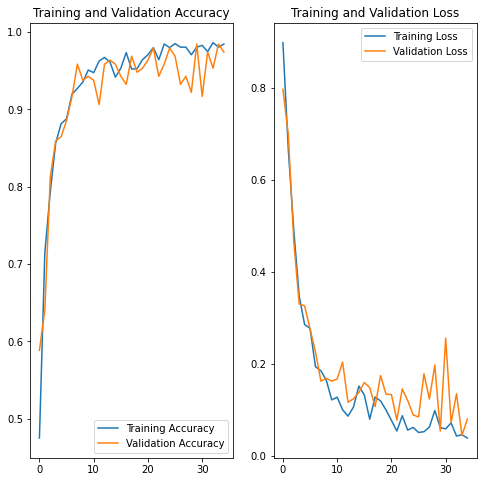

In [92]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


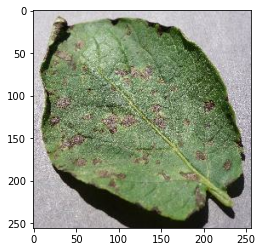

In [93]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    #plt.axis('off')
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [94]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converting image to tensor
    img_array = tf.expand_dims(img_array, 0) #changing it in batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]  #prediction[0] will be the first image of batch 
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

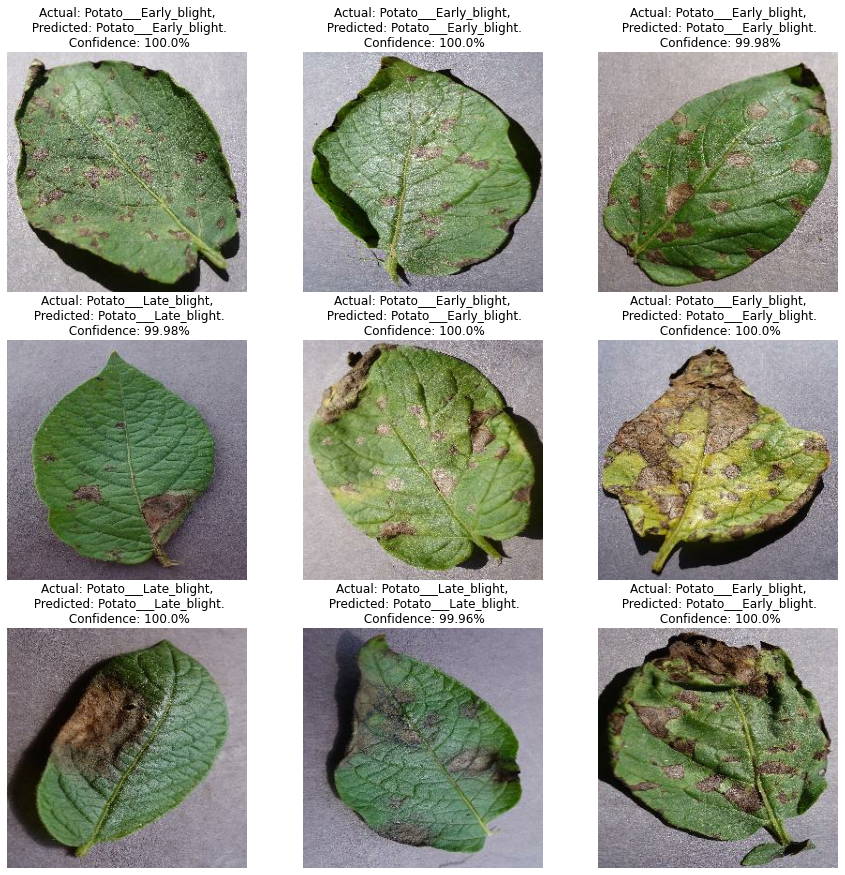

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.set_axis_off()
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        #plt.axis("off")

In [42]:
import os
model_version ='models'
#model_version=max([int(i) for i in os.listdir("../plant check") + [0]])+1
model.save(f"C/ProgramData/Anaconda3/{model_version}")

KeyError: "Failed to add concrete function 'b'__inference_sequential_3_layer_call_fn_21750'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."

In [41]:
from platform import python_version

print(python_version())

3.8.12


In [96]:
model.save("./potatoes.h5")

In [97]:
from tensorflow import keras
modelle = keras.models.load_model('./potatoes.h5')